# Conditional Generative Advarsarial Network 

Here is presented the implementation of the following parper https://arxiv.org/abs/1411.1784

This work is similar to the previous one but now the G(z) is replaced with G(z|y) and D(x) by D(x|y). 
Since we only need to modify the Generator and Discriminator network the previous code dont change to much (loss, otimization)

Implementation is done in tensorflow using layers API

Created by: Tiago Almeida 02/02/2018

In [1]:
##imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data MNIST

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


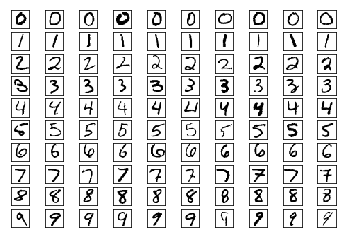

In [2]:
mnist_flat_size = 784

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data")

#ut.plot_mnist_images(mnist.test.images[0:9])

#reset graph using during notebook development
#tf.reset_default_graph()
images_per_class = 10
images = np.zeros((10*images_per_class,mnist_flat_size))
for l in range(10):
    images[(l*images_per_class):(l*images_per_class+images_per_class)] = mnist.test.images[(mnist.test.labels==l)][:images_per_class]
    
ut.plot_mnist_images_conditonal(images,per_class = images_per_class)


### Generator network 

Same as previous network, only diference is that input Z is concatenated with y

In [3]:
#array that contain the network dimention at least 3 dimention (input, hidden and output dimentions)
z_dimention = 100

G_dimentions = [z_dimention,128,mnist_flat_size]

Z = tf.placeholder(tf.float32, shape=[None, G_dimentions[0]], name='x_generator_input')
Y = tf.placeholder(tf.float32, shape=[None, 10], name='number_label')

def generator(x,y):
    '''
    Generator implemented as MLP
    
    :param x: tensor with shape (M,100) here M = number of samples
    :param y: tensor with shape (M,10) labels in one hot encoder
    :return: tensor with shape (M,784) corresponding to the image (28x28) mapping between x and data distribution (pData)
    '''
    with tf.name_scope("generator_nn"):

        he_init = tf.contrib.layers.variance_scaling_initializer()
        
        concat_input = tf.concat([x, y], 1)
        
        g_net = tf.layers.dense(concat_input,G_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='g_hidden1',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        for i in range(2,len(G_dimentions)-1):#loop throw hidden layers
            g_net = tf.layers.dense(g_net,G_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='g_hidden'+str(i),reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        g_net = tf.layers.dense(g_net,G_dimentions[-1],activation=tf.nn.sigmoid,name='g_output',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        return g_net


### Discriminator network 

Same as previous network, only diference is that input Z is concatenated with y

In [4]:
#array that contain the network dimention at least 3 dimention (input and output dimentions)
D_dimentions = [mnist_flat_size,128,1] ##ouput fake, true

X = tf.placeholder(tf.float32, shape=[None, D_dimentions[0]], name='x_discriminator_input')

def discriminator(x,y):
    '''
    Discriminator implemented as MLP
    
    :param x: tensor with shape (M,784) here M = number of samples
    :param y: tensor with shape (10,1) labels in one hot encoder
    :return: tensor with shape (M,1) corresponding to the probability of each sample being true or fake
    '''
    with tf.name_scope("discriminator_nn"):
        he_init = tf.contrib.layers.variance_scaling_initializer()
        concat_input = tf.concat([x, y], 1)
        
        d_net = tf.layers.dense(concat_input,D_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='d_hidden1',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        for i in range(2,len(D_dimentions)-1):#loop throw hidden layers
            d_net = tf.layers.dense(d_net,D_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='d_hidden'+str(i),reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        d_net = tf.layers.dense(d_net,D_dimentions[-1],activation=None,name='d_output',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        #save the logits before the sigmoid activation (ouput between[0,1]) for alternative loss function
        d_logits = d_net
        d_net = tf.nn.sigmoid(d_net)
        return d_net,d_logits

### Loss functions Generator and Discriminator

Same as previous one

In [5]:

#this alternative loss use cross entropy (explanation why this makes senses TODO)
alternative_loss = True

with tf.name_scope("generator_loss"): 
    generated_sample = generator(Z,Y)
    d_fake_prob, d_fake_logits = discriminator(generated_sample,Y) #D(G(Z|Y)|Y)
    
    if alternative_loss:
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    else:
        g_loss = -tf.reduce_mean(tf.log(d_fake_prob))

with tf.name_scope("discriminator_loss"):
    d_true_prob, d_true_logits = discriminator(X,Y)
    if alternative_loss:
        d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_true_logits, labels=tf.ones_like(d_true_logits)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
        d_loss = d_loss_fake + d_loss_true
    else:
        d_loss = -tf.reduce_mean(tf.log(d_true_prob) + tf.log(1. - d_fake_prob))

#### Geting the trainable variables for generator and the discriminator (disadvantage of using layers API)

In [6]:
generator_variables = [var for var in tf.trainable_variables() if 'g_' in var.name]
discriminator_variables = [var for var in tf.trainable_variables() if 'd_' in var.name]

# kernel = weight
print(generator_variables)
print(discriminator_variables)

[<tf.Variable 'g_hidden1/kernel:0' shape=(110, 128) dtype=float32_ref>, <tf.Variable 'g_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'g_output/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'g_output/bias:0' shape=(784,) dtype=float32_ref>]
[<tf.Variable 'd_hidden1/kernel:0' shape=(794, 128) dtype=float32_ref>, <tf.Variable 'd_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'd_output/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'd_output/bias:0' shape=(1,) dtype=float32_ref>]


## Train cGAN

Epoach 0
Discriminator loss:  1.06089
Generator loss: 2.90124


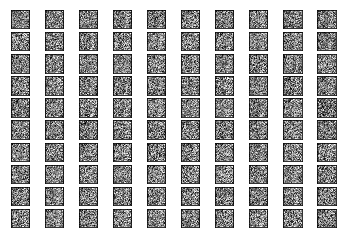

Epoach 1000
Discriminator loss:  0.00602153
Generator loss: 13.485


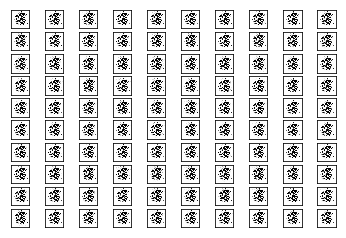

Epoach 2000
Discriminator loss:  0.00565318
Generator loss: 8.38623


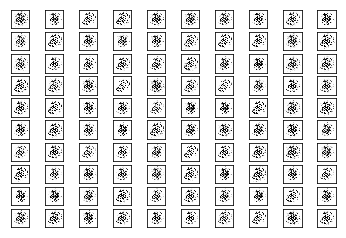

Epoach 3000
Discriminator loss:  0.0230764
Generator loss: 6.06018


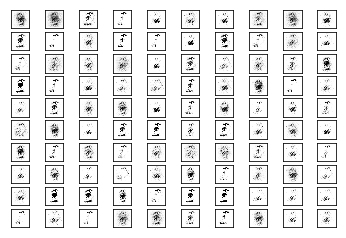

Epoach 4000
Discriminator loss:  0.0209609
Generator loss: 8.42763


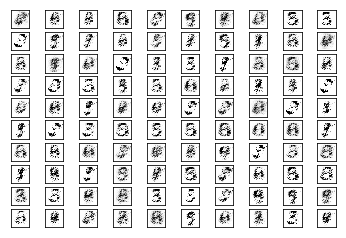

Epoach 5000
Discriminator loss:  0.296595
Generator loss: 4.97498


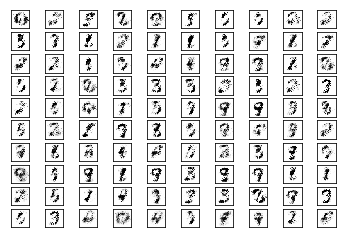

Epoach 6000
Discriminator loss:  0.301356
Generator loss: 5.10152


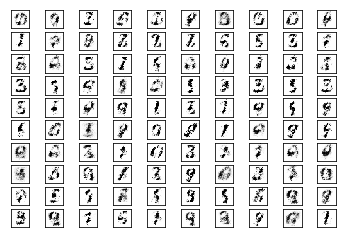

Epoach 7000
Discriminator loss:  0.198049
Generator loss: 4.57219


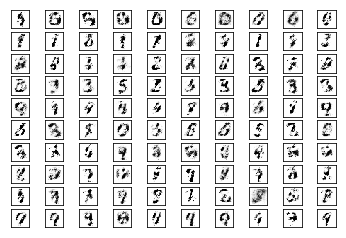

Epoach 8000
Discriminator loss:  0.286295
Generator loss: 4.37163


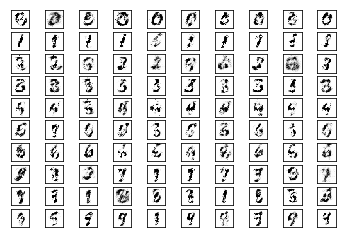

Epoach 9000
Discriminator loss:  0.672269
Generator loss: 3.4617


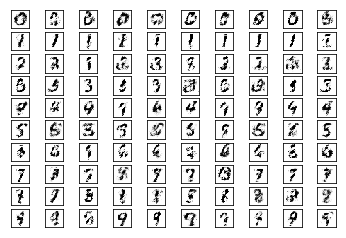

Epoach 10000
Discriminator loss:  0.327699
Generator loss: 3.60856


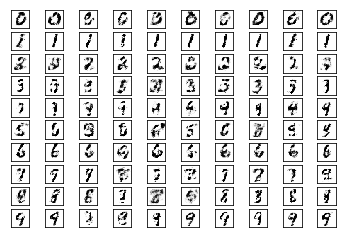

Epoach 11000
Discriminator loss:  0.52488
Generator loss: 2.86766


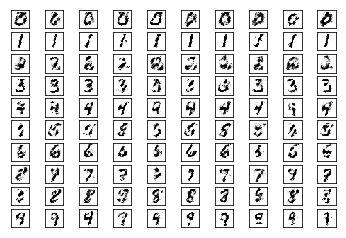

Epoach 12000
Discriminator loss:  0.468458
Generator loss: 3.38663


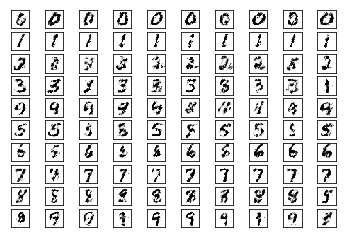

Epoach 13000
Discriminator loss:  0.621245
Generator loss: 2.46451


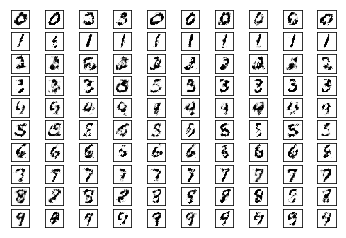

Epoach 14000
Discriminator loss:  0.732508
Generator loss: 2.71274


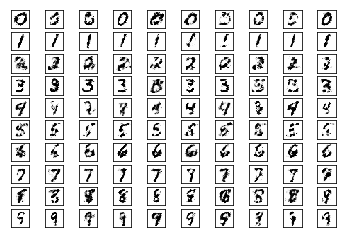

Epoach 15000
Discriminator loss:  0.626829
Generator loss: 2.92816


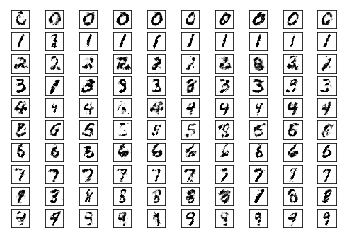

Epoach 16000
Discriminator loss:  0.757473
Generator loss: 2.34971


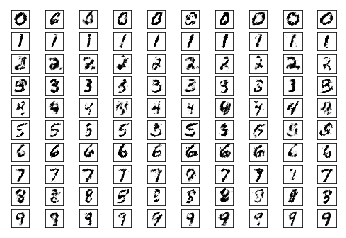

Epoach 17000
Discriminator loss:  0.733894
Generator loss: 2.45959


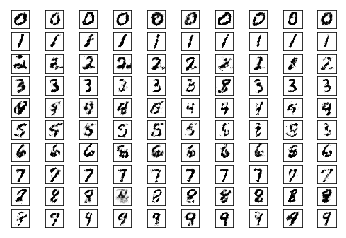

Epoach 18000
Discriminator loss:  0.819367
Generator loss: 1.87474


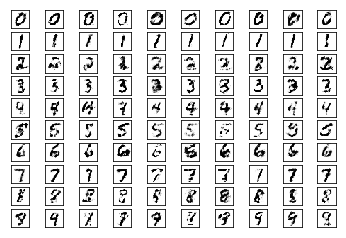

Epoach 19000
Discriminator loss:  0.970168
Generator loss: 2.34323


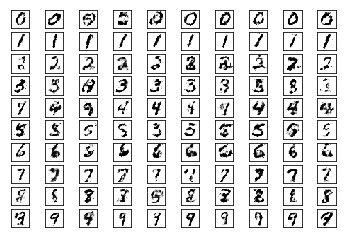

Epoach 20000
Discriminator loss:  0.846854
Generator loss: 2.4091


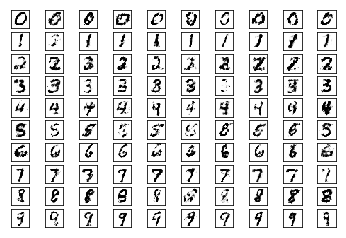

In [10]:
lr=0.001
with tf.name_scope("discriminator_train"):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    d_train_op = d_optimizer.minimize(d_loss, var_list=discriminator_variables) # note minimizing negative loss is the same as maximizing, tf dont have maximizing

with tf.name_scope("generator_train"):
    g_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    g_train_op = g_optimizer.minimize(g_loss,var_list=generator_variables)


## Start graph computations and algorithm


batch_size = 128
epoach = 200000

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epoach+1):
    x_train,y_train = mnist.train.next_batch(batch_size)
    
    y_one_hot = ut.one_hot(y_train)
    #print(y_one_hot)
    #first discriminator
    _, d_loss_value = sess.run([d_train_op, d_loss], feed_dict={X: x_train,Y:y_one_hot , Z: ut.random_Z(batch_size,n=z_dimention)})
    #second generator
    _, g_loss_value = sess.run([g_train_op, g_loss], feed_dict={Z: ut.random_Z(batch_size,n=z_dimention),Y:y_one_hot})

    if i%1000 == 0:
        print("Epoach",i)
        print("Discriminator loss: ",d_loss_value)
        print("Generator loss:",g_loss_value)
        #print("D_sample",d_sample)
        #print("G_sample",g_sample)
        
        #visual progress of training
        z_new = ut.random_Z(images_per_class*10,n=z_dimention)
                
        conditional_y = ut.one_hot(np.repeat(list(range(10)), images_per_class))
        
        generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new,Y:conditional_y})
        ut.plot_mnist_images_conditonal(generated_images,per_class = images_per_class)

### Play with the model

[-1.   -0.78 -0.56 -0.34 -0.12  0.1   0.32  0.54  0.76  0.98]


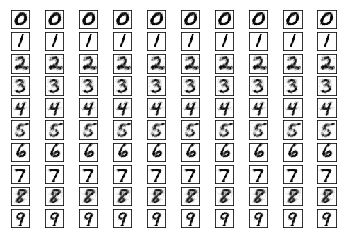

In [11]:
z_noise = np.zeros((images_per_class*10,z_dimention))


range_values = np.arange(-1, 1, 0.22)
print(range_values)
for i in range(len(range_values)):
    z_noise[i][0]=range_values[i]
    
conditional_y = ut.one_hot(np.repeat(list(range(10)), images_per_class))

#valores altos de indice 0 permitem criar 0 mais grosso

ut.plot_mnist_images_conditonal(generated_sample.eval(session=sess,feed_dict={Z: z_noise,Y:conditional_y}),per_class=images_per_class)